In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
from models.gru import GRU
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
#from models.gru_exp import GRU
#from models.gru_stacked import GRU_Stacked

In [2]:
base_dir = "/scratch/yjk27/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "V_diff_stimseed1_set1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

#####
#V_test_raw = np.load("/media/hdd01/sklee/"+experiment+"/data/V_diff_stimseed1.npy")
#V_test_raw = torch.from_numpy(V_test_raw)
#V_test_raw -= torch.mean(V_test_raw)

#test_E_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Espikes_neural.npz")
#test_I_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Ispikes_neural.npz")
#####

C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_e.npy")
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 20
sub_no = 5
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda:1")

#layer_no = 3

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

#V_test = V_test_raw[50000*993:50000*994].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
#test_E_neural = E_neural[50000*993:50000*994].toarray()
#test_I_neural = I_neural[50000*993:50000*994].toarray()
#test_E_neural = test_E_neural_raw[50000*993:50000*994].toarray()
#test_I_neural = test_I_neural_raw[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = GRU_Stacked(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

9206


In [ ]:
score_list = []

for i in tnrange(iter_no):
#for i in tnrange(12000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    train_score = explained_variance_score(batch_V[:,:].flatten().cpu().detach().numpy(),
                                           V_pred.flatten().cpu().detach().numpy())
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-6-c66b9cb13dd9>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.00256 0.003804


(0.0, 1.0)

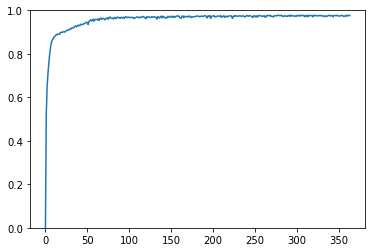

In [7]:
plt.plot(np.asarray(score_list))
plt.ylim(0,1)

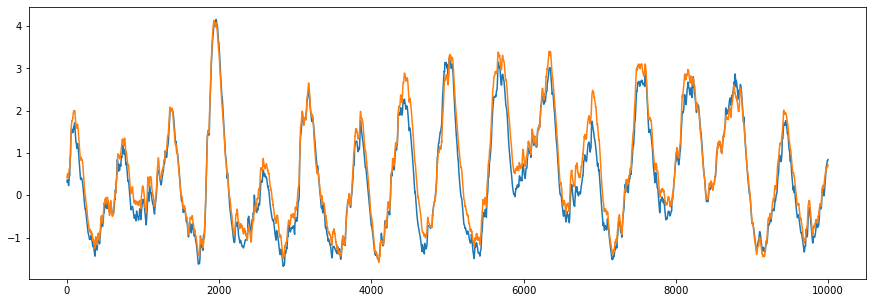

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust12-20_noNA/hand/glm_s13_h3.pt")